In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analyze import DataLoad

__version__ = 0.0001

In [25]:
class TrendPower:
    def __init__(self, 
                 loader: DataLoad,
                 use_trend_powers=(0.15, 0.075, 0.055, 0.0275, 0.01375),
                ):
        self.loader = loader
        self.use_trend_powers = use_trend_powers
        self.pair_symbol: str = None
        self.timeframe : str = None
        self.trend_base: dict = {}
        pass
    

    def run(self, pair_symbol, timeframe):
        self.pair_symbol = pair_symbol
        self.timeframe = timeframe
        print(self.loader.ohlcvbase.keys())
        assert f'{pair_symbol}-{timeframe}' in self.loader.ohlcvbase.keys(), f'Error: {pair_symbol}-{timeframe} not found in loader base'  
        self.prepare_trends_data()
        self.check_trend_powers()
        pass
    
    
    def prepare_trends_data(self) -> None:
        """
        Returns:
            None:
        """
        for trend_power in self.use_trend_powers:
            print(f'Preparing trend with power {trend_power}...')
            trend_df= self.calculate_trend(self.loader.ohlcvbase[f'{self.pair_symbol}-{self.timeframe}'].df, W=trend_power)
            self.trend_base.update({trend_power: trend_df.copy()})
        pass
 

    def check_trend_powers(self) -> None:
        """
        Returns:
            None:
        """
        data_df = self.loader.ohlcvbase[f'{self.pair_symbol}-{self.timeframe}'].df.copy()
        
        for trend_power in self.use_trend_powers:
            trend_df = self.trend_base[trend_power].copy()
            # for visualization we use scaling of trend = 1 to data_df["close"].max()
            max_close = data_df["close"].max()
            min_close = data_df["close"].min()
            mean_close = data_df["close"].mean()
            trend_df.loc[(trend_df["trend"] == 1), "trend"] = max_close
            trend_df.loc[(trend_df["trend"] == -1), "trend"] = min_close
            trend_df.loc[(trend_df["trend"] == 0), "trend"] = mean_close
            data_df[f"trend_{trend_power}"] = trend_df["trend"]

        powers_len = len(self.use_trend_powers)
        fig = plt.figure(figsize=(45, 6 * powers_len))

        for i, trend_power in enumerate(self.use_trend_powers):
            ax1 = fig.add_subplot(powers_len, 1, i+1)
            # Don't allow the axis to be on top of your data
            ax1.set_axisbelow(True)
            # Turn on the minor TICKS, which are required for the minor GRID
            ax1.minorticks_on()
            # Customize the major grid
            ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
            # Customize the minor grid
            ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            # ax1.plot(data_df.index, data_df["close"],  'b-')
            # ax2 = ax1.twinx()
            ax1.plot(data_df.index, data_df[f"trend_{trend_power}"], data_df.index, data_df["close"])
            ax1.set_ylabel(f'trend power = {trend_power}', color='r')
            plt.title(f"Trend with weight: {trend_power}")
        plt.show()
        pass

    @staticmethod
    def calculate_trend(input_df: pd.DataFrame,
                        W: float = 0.15
                        ) -> pd.DataFrame:
        """
        Args:
            input_df (pd.DataFrame):    input DataFrame with index and OHCLV data
            W (float):                  weight percentage for calc trend default 0.15
        Returns:
           trend (pd.DataFrame):        output DataFrame
        """
                                            
        """
        Setup. Getting first data and initialize variables
        """
        x_bar_0 = [input_df.index[0],    # [0] - datetime
                   input_df["open"][0],  # [1] - open
                   input_df["high"][0],  # [2] - high
                   input_df["low"][0],   # [3] - low
                   input_df["close"][0], # [4] - CLOSE
                   ]
        FP_first_price = x_bar_0[4]
        xH_highest_price = x_bar_0[2]
        HT_highest_price_timemark = 0
        xL_lowest_price = x_bar_0[3]
        LT_lowest_price_timemark = 0
        Cid = 0
        FPN_first_price_idx = 0
        Cid_array = np.zeros(input_df.shape[0])
        """
        Setup. Getting first data and initialize variables
        """

        for idx in range(input_df.shape[0] - 1):
            x_bar = [input_df.index[idx],
                     input_df["open"][idx],
                     input_df["high"][idx],
                     input_df["low"][idx],
                     input_df["close"][idx],
                     ]
            # print(x_bar)
            # print(x_bar[4])
            if x_bar[2] > (FP_first_price + x_bar_0[4] * W):
                xH_highest_price = x_bar[2]
                HT_highest_price_timemark = idx
                FPN_first_price_idx = idx
                Cid = 1
                Cid_array[idx] = 1
                Cid_array[0] = 1
                break
            if x_bar[3] < (FP_first_price - x_bar_0[4] * W):
                xL_lowest_price = x_bar[3]
                LT_lowest_price_timemark = idx
                FPN_first_price_idx = idx
                Cid = -1
                Cid_array[idx] = -1
                Cid_array[0] = -1
                break

        for ix in range(FPN_first_price_idx + 1, input_df.shape[0] - 2):
            x_bar = [input_df.index[ix],
                     input_df["open"][ix],
                     input_df["high"][ix],
                     input_df["low"][ix],
                     input_df["close"][ix],
                     ]
            if Cid > 0:
                if x_bar[2] > xH_highest_price:
                    xH_highest_price = x_bar[2]
                    HT_highest_price_timemark = ix
                if x_bar[2] < (
                        xH_highest_price - xH_highest_price * W) and LT_lowest_price_timemark <= HT_highest_price_timemark:
                    for j in range(1, input_df.shape[0] - 1):
                        if LT_lowest_price_timemark < j <= HT_highest_price_timemark:
                            Cid_array[j] = 1
                    xL_lowest_price = x_bar[2]
                    LT_lowest_price_timemark = ix
                    Cid = -1

            if Cid < 0:
                if x_bar[3] < xL_lowest_price:
                    xL_lowest_price = x_bar[3]
                    LT_lowest_price_timemark = ix
                if x_bar[3] > (
                        xL_lowest_price + xL_lowest_price * W) and HT_highest_price_timemark <= LT_lowest_price_timemark:
                    for j in range(1, input_df.shape[0] - 1):
                        if HT_highest_price_timemark < j <= LT_lowest_price_timemark:
                            Cid_array[j] = -1
                    xH_highest_price = x_bar[2]
                    HT_highest_price_timemark = ix
                    Cid = 1

        # TODO: rewrite this block in intelligent way !!! Now is working but code is ugly
        """ Checking last bar in input_df """
        ix = input_df.shape[0] - 1
        x_bar = [input_df.index[ix],
                 input_df["open"][ix],
                 input_df["high"][ix],
                 input_df["low"][ix],
                 input_df["close"][ix],
                 ]
        if Cid > 0:
            if x_bar[2] > xH_highest_price:
                xH_highest_price = x_bar[2]
                HT_highest_price_timemark = ix
            if x_bar[2] <= xH_highest_price:
                for j in range(1, input_df.shape[0]):
                    if LT_lowest_price_timemark < j <= HT_highest_price_timemark:
                        Cid_array[j] = 1
                xL_lowest_price = x_bar[3]
                LT_lowest_price_timemark = ix
                Cid = -1
        if Cid < 0:
            if x_bar[3] < xL_lowest_price:
                xL_lowest_price = x_bar[3]
                LT_lowest_price_timemark = ix
                # print(True)
            if x_bar[3] >= xL_lowest_price:
                for j in range(1, input_df.shape[0]):
                    if HT_highest_price_timemark < j <= LT_lowest_price_timemark:
                        Cid_array[j] = -1
                xH_highest_price = x_bar[2]
                HT_highest_price_timemark = ix
                Cid = 1
        if Cid > 0:
            if x_bar[2] > xH_highest_price:
                xH_highest_price = x_bar[2]
                HT_highest_price_timemark = ix
            if x_bar[2] <= xH_highest_price:
                for j in range(1, input_df.shape[0]):
                    if LT_lowest_price_timemark < j <= HT_highest_price_timemark:
                        Cid_array[j] = 1
                # xL_lowest_price = x_bar[3]
                # LT_lowest_price_timemark = ix
                # Cid = -1
        trend = pd.DataFrame(data=Cid_array,
                             index=input_df.index,
                             columns=["trend"])
        return trend  



{'interval': ['1m', '1m'], 'pair': ['ETHBTC', 'ETHUSDT'], 'file_name': ['/home/cubecloud/Python/projects/paired_trading/source_root/1m/ETHBTC-1m-data.csv', '/home/cubecloud/Python/projects/paired_trading/source_root/1m/ETHUSDT-1m-data.csv']}
dict_keys(['ETHBTC-1m', 'ETHUSDT-1m'])
Preparing trend with power 0.15...
Preparing trend with power 0.075...
Preparing trend with power 0.055...
Preparing trend with power 0.0275...
Preparing trend with power 0.01375...


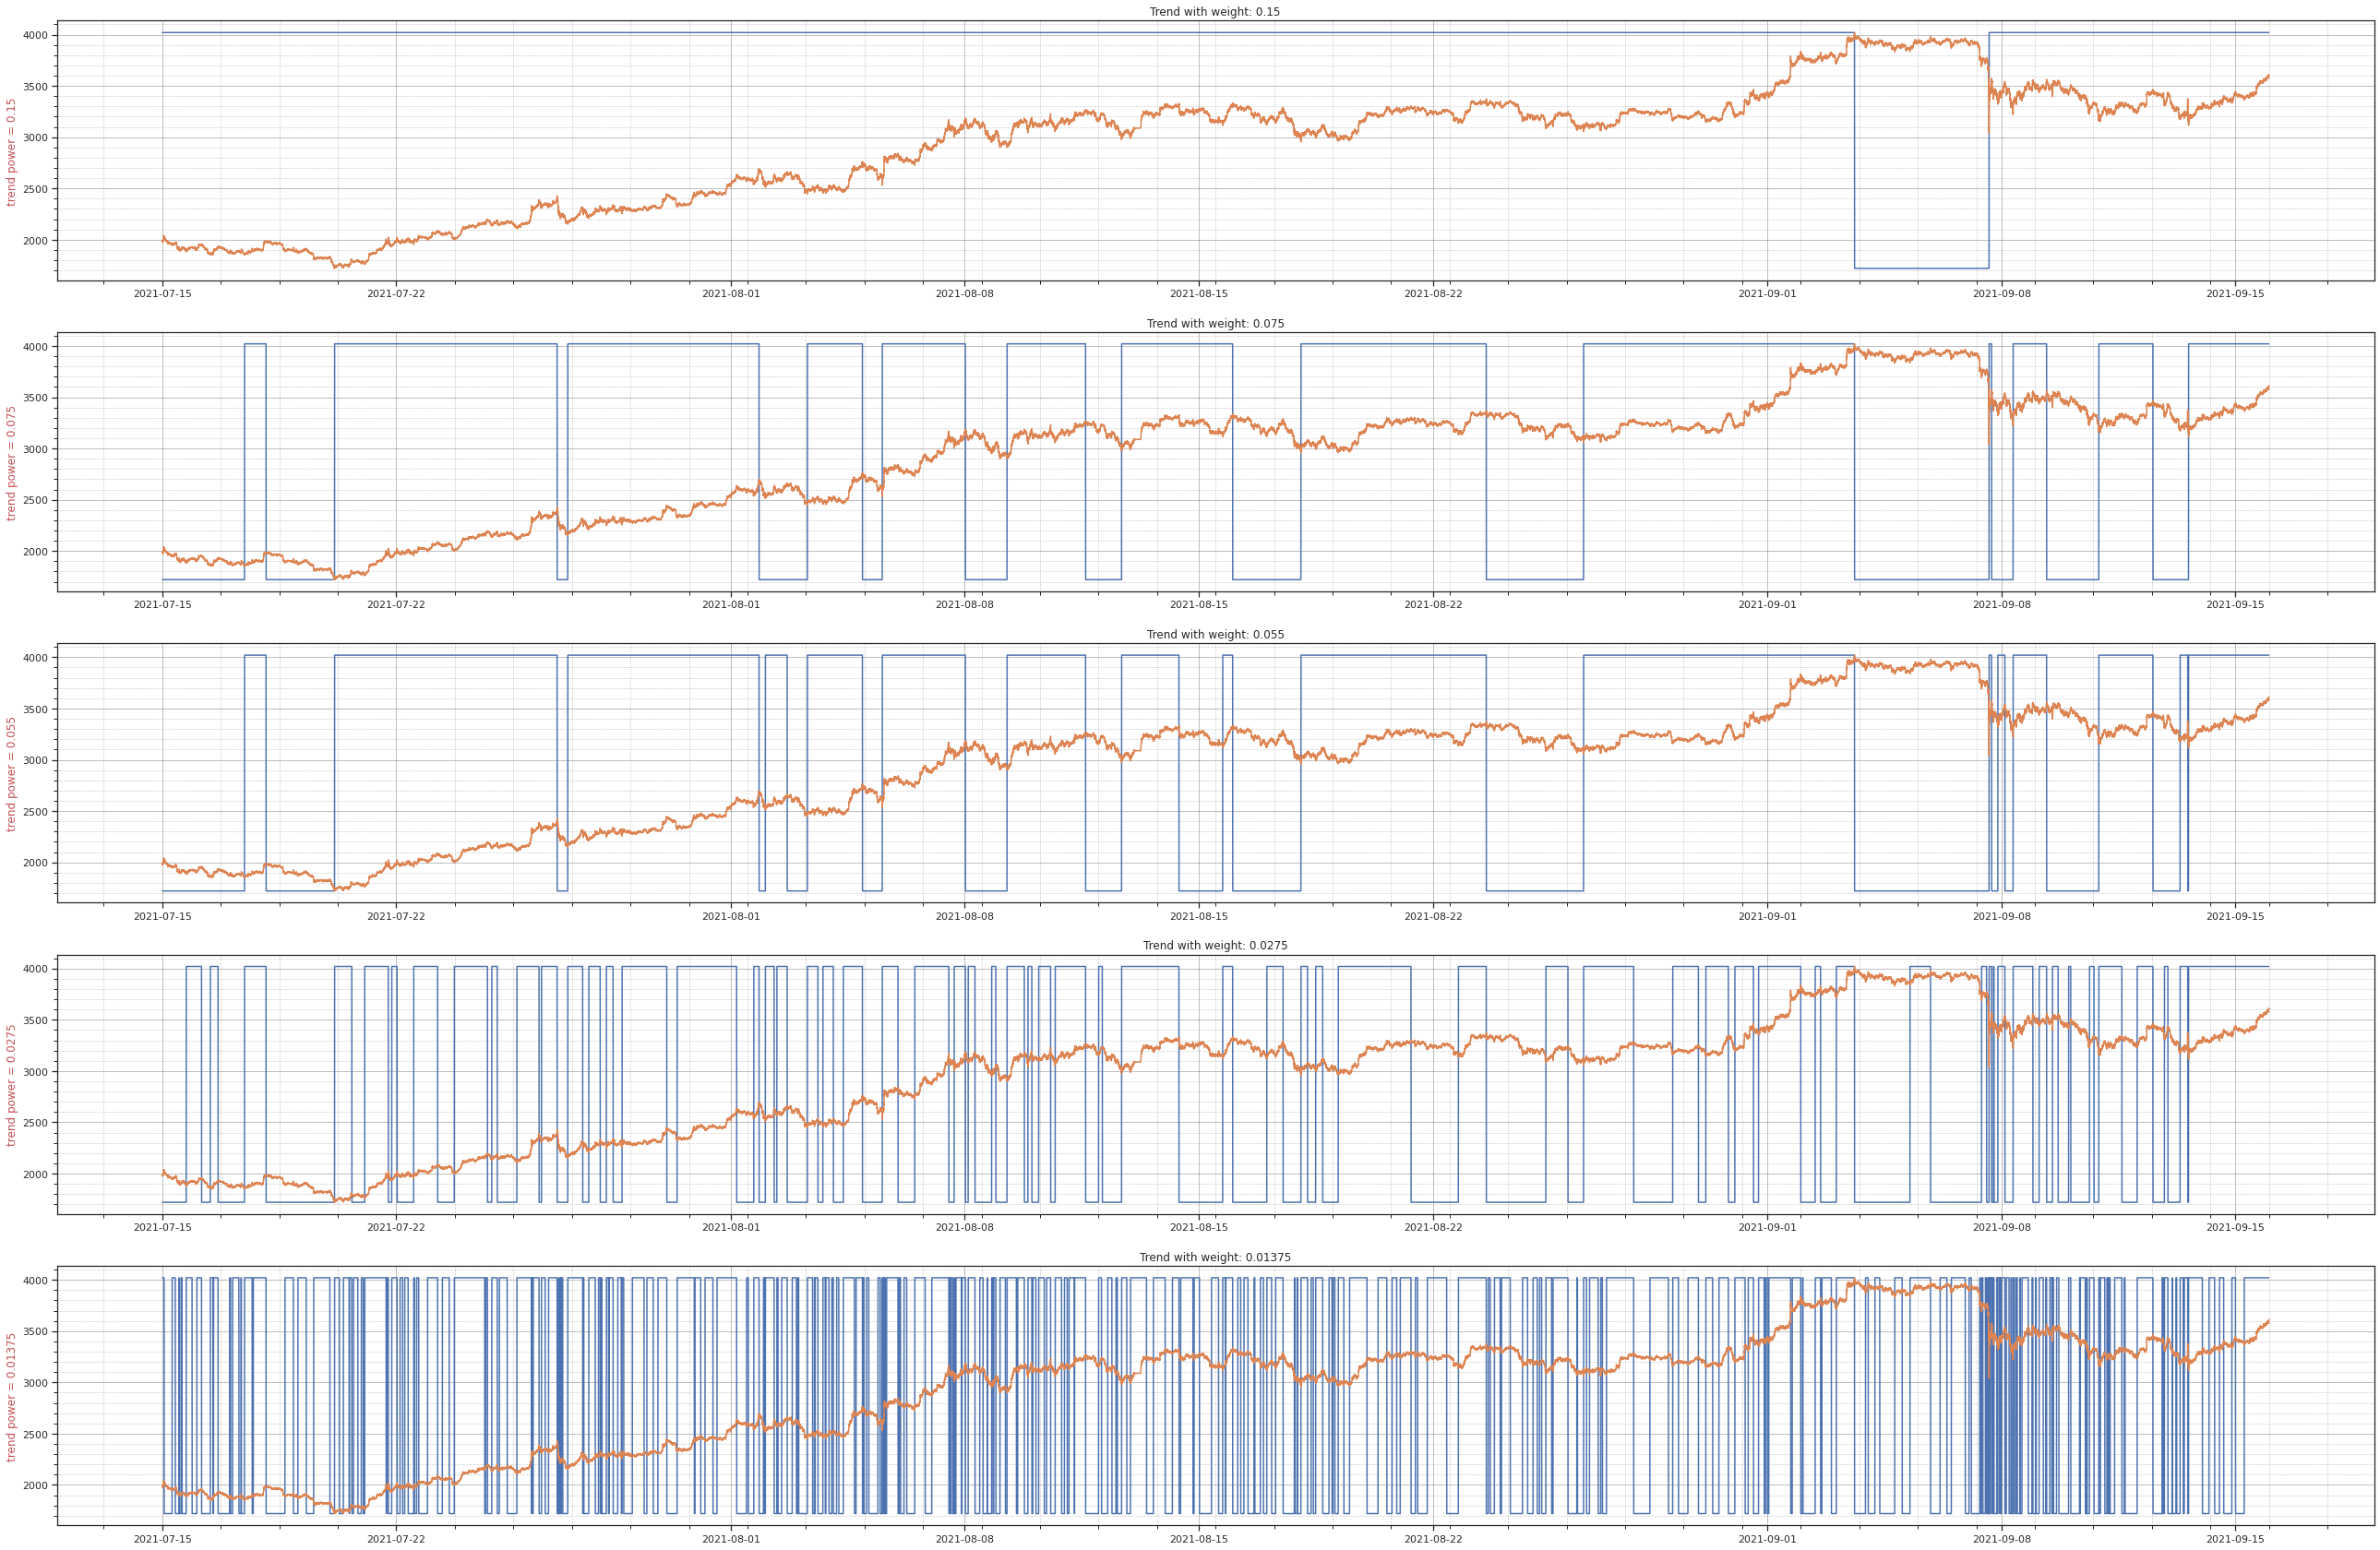

In [24]:
pd.set_option('display.max_colwidth', None)

intervals = ['1m']
root_path = os.getcwd()
source_root_path = os.path.join(root_path, 'source_root')

loaded_crypto_data = DataLoad(pairs_symbols=None,
                              time_intervals=['1m'],
                              source_directory=source_root_path,
                              start_period='2021-07-15 00:00:00',
                              end_period='2021-09-15 23:59:59',
                              )


tp = TrendPower(loaded_crypto_data)
tp.run(pair_symbol='ETHUSDT', timeframe='1m')


In [3]:
import pandas as pd
import operator
    
class Test:
    def __init__(self)
    self.arg = 1
    self.temp = pd.Series()
    self.a: dict = { 'mean': self.temp.mean(axis=self.arg),
                     '678': 90  }

    self.b: dict = {}

    def dict_update(self):
        self.b = self.b
    
    def run(self)
    b = {*a.items()}

    b


{('123', 456), ('678', 90)}